In [4]:
import pandas as pd
import seaborn as sns

# 01 Selecting dataset from Kaggle

In [5]:
train_df = pd.read_csv('./data/train.csv', delimiter=';')
test_df = pd.read_csv('./data/test.csv', delimiter=';')

## 02 EDA

In [6]:
train_df.head()

,id,year,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,3,2012,23,3,0,0,2,23.78,27.275,73,11.0014,133
1,4,2011,8,3,0,0,1,27.88,31.820,57,0.0000,132
2,5,2012,2,1,0,1,1,20.50,24.240,59,0.0000,19
3,7,2011,20,3,0,1,3,25.42,28.790,83,19.9995,58
4,8,2011,17,3,0,1,3,26.24,28.790,89,0.0000,285


## Datasets contains any null values?

In [7]:
train_df.isnull().values.any(), test_df.isnull().values.any()

(False, False)

Datasets contains any N/A values?

In [8]:
train_df.isna().values.any(), test_df.isna().values.any()

(False, False)

### Plot correlation between rentals and the season

Seasons: 
 * 1 = winter
 * 2 = spring
 * 3 = summer
 * 4 = autumn

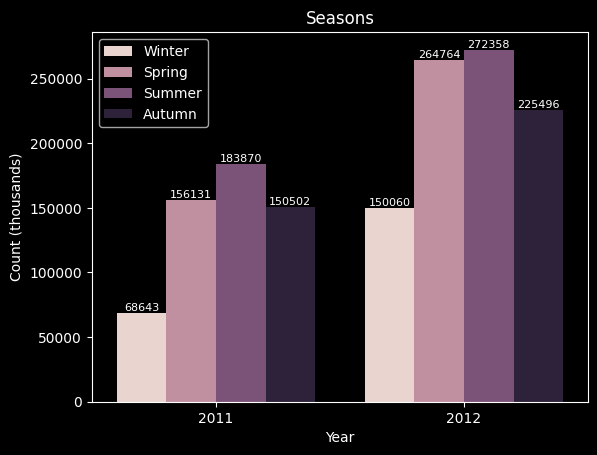

In [9]:
ax = sns.barplot(
    x="year", y="count", hue="season", data=train_df, errorbar=None, estimator="sum"
)
ax.set_title('Seasons')
ax.set_ylabel("Count (thousands)")
ax.set_xlabel("Year")
ax.bar_label(ax.containers[0], fontsize=8)
ax.bar_label(ax.containers[1], fontsize=8)
ax.bar_label(ax.containers[2], fontsize=8)
ax.bar_label(ax.containers[3], fontsize=8)
ax.legend(labels=["Winter", "Spring", "Summer", "Autumn"]);

### Plot correlation between rentals and hour

<Axes: xlabel='year', ylabel='count'>

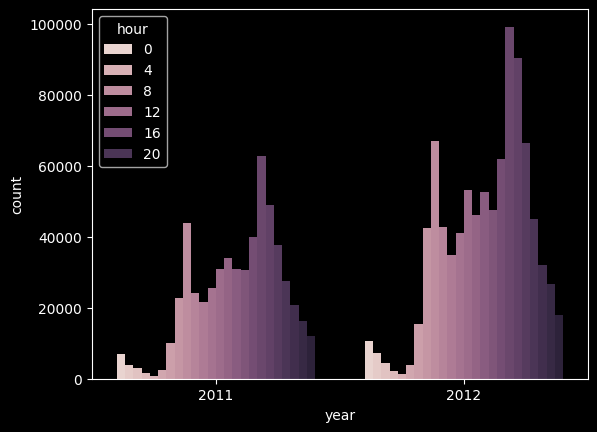

In [10]:
sns.barplot(
    x="year", y="count", hue="hour", data=train_df, errorbar=None, estimator="sum"
)

### Plot correlation between rentals and wheaver

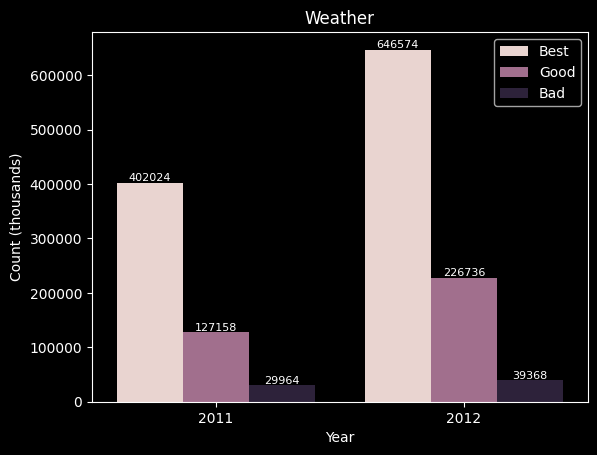

In [11]:
ax = sns.barplot(
    x="year", y="count", hue="weather", data=train_df, errorbar=None, estimator="sum"
)
ax.set_title('Weather')
ax.set_ylabel("Count (thousands)")
ax.set_xlabel("Year")
ax.bar_label(ax.containers[0], fontsize=8)
ax.bar_label(ax.containers[1], fontsize=8)
ax.bar_label(ax.containers[2], fontsize=8)
ax.legend(labels=["Best", "Good", "Bad"]);

## 03 Preprocessing

In [12]:
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector

### (a) - data cleaning

Nothing to do.

### (b) - data completion

Nothing to do.

### (c) - reducing dimentions


It is obvious that **temp** (temperature in degrees Celsius) and **atemp**: (sensation of temperature in degrees Celsius) are correlated to each other. In addition, **temperature**, **humidity** and **windspeed** are correlating with categorical variable **weather**.

It could make sense to create a single variable out of **temp** and **atemp** instead of 2, but instead of guessing, we will perform precise feature selection later on, instead of taking guesses. Our data have 10 predictors,  which isn't that much, and plenty of training and testing data. It is not imperative to reduce dimensions. We will evaluate each predictor later on.


We have a 'year' predictor, and this might be a problem. Renting in one year might be significantly different from the rents in another year due to various reasons: global events, such as pandemic, war, volcano eruption, etc...

Let's take a look at averages of renting by the year:

In [13]:
df_raw = pd.read_csv('./data/train.csv', sep=';')

def print_mean_and_std(year):
    filtered_df = df_raw[df_raw['year'] == year]
    print(f"{year} mean: {filtered_df['count'].mean()}, std: {filtered_df['count'].std()}")

print_mean_and_std(2011)
print_mean_and_std(2012)

2011 mean: 144.14694508894044, std: 134.36129950191017
2012 mean: 239.548031496063, std: 209.73105063880573


The differences in mean and standard deviation between 2011 and 2012 suggest there is a temporal trend in the data.

Year is just a proxy for temporal drift or trend.

"year" correlates strongly with the response variable (sales) but doesn't provide actionable insights for future predictions (e.g., predicting 2013 or later), it might act as a confounding variable, misleading the model.

**We will remove year from our predictors**

### (d) - balancing data

Nothing to do.

### (e) - data normalization

In [14]:
# 1. Drop unnecessary columns
df = df_raw.drop(columns=['id', 'year'], axis=1)
df

,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,23,3,0,0,2,23.78,27.275,73,11.0014,133
1,8,3,0,0,1,27.88,31.820,57,0.0000,132
2,2,1,0,1,1,20.50,24.240,59,0.0000,19
3,20,3,0,1,3,25.42,28.790,83,19.9995,58
4,17,3,0,1,3,26.24,28.790,89,0.0000,285
...,...,...,...,...,...,...,...,...,...,...
7684,18,1,0,1,1,13.94,15.150,42,22.0028,457
7685,3,1,0,1,1,9.02,11.365,51,11.0014,1
7686,15,2,0,0,1,21.32,25.000,19,27.9993,626
7687,19,4,0,1,1,12.30,14.395,45,15.0013,217


In [15]:
# Split data into features (X) and target (y)
X = df.drop('count', axis=1)
y = df['count'] 
X

,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,23,3,0,0,2,23.78,27.275,73,11.0014
1,8,3,0,0,1,27.88,31.820,57,0.0000
2,2,1,0,1,1,20.50,24.240,59,0.0000
3,20,3,0,1,3,25.42,28.790,83,19.9995
4,17,3,0,1,3,26.24,28.790,89,0.0000
...,...,...,...,...,...,...,...,...,...
7684,18,1,0,1,1,13.94,15.150,42,22.0028
7685,3,1,0,1,1,9.02,11.365,51,11.0014
7686,15,2,0,0,1,21.32,25.000,19,27.9993
7687,19,4,0,1,1,12.30,14.395,45,15.0013


In [16]:
categorical_cols = ["season", "weather", "holiday", "workingday"]
non_categorical_cols =  X.columns.drop(categorical_cols)
non_categorical_cols

Index(['hour', 'temp', 'atemp', 'humidity', 'windspeed'], dtype='object')

In [17]:
X[non_categorical_cols]

,hour,temp,atemp,humidity,windspeed
0,23,23.78,27.275,73,11.0014
1,8,27.88,31.820,57,0.0000
2,2,20.50,24.240,59,0.0000
3,20,25.42,28.790,83,19.9995
4,17,26.24,28.790,89,0.0000
...,...,...,...,...,...
7684,18,13.94,15.150,42,22.0028
7685,3,9.02,11.365,51,11.0014
7686,15,21.32,25.000,19,27.9993
7687,19,12.30,14.395,45,15.0013


In [18]:
scaler = StandardScaler()
X_scaled  = scaler.fit_transform(X[non_categorical_cols])
X_scaled

array([[ 1.65352224,  0.44901756,  0.42031574,  0.58176099, -0.22017498],
       [-0.5155726 ,  0.97307586,  0.9541646 , -0.24721608, -1.56535958],
       [-1.38321054,  0.02977093,  0.0638292 , -0.14359394, -1.56535958],
       ...,
       [ 0.49667166,  0.13458259,  0.15309766, -2.2160366 ,  1.85822533],
       [ 1.07509695, -1.01834566, -1.0925497 , -0.86894887,  0.26890857],
       [ 1.3643096 ,  1.28751084,  1.31006385,  0.21908352, -0.70925854]])

In [19]:
# make a dataframe from the scaled data
X_scaled_df = pd.DataFrame(X_scaled, columns=non_categorical_cols)
X_scaled_df


,hour,temp,atemp,humidity,windspeed
0,1.653522,0.449018,0.420316,0.581761,-0.220175
1,-0.515573,0.973076,0.954165,-0.247216,-1.565360
2,-1.383211,0.029771,0.063829,-0.143594,-1.565360
3,1.219703,0.658641,0.598265,1.099872,0.880058
4,0.785884,0.763453,0.598265,1.410738,-1.565360
...,...,...,...,...,...
7684,0.930491,-0.808722,-1.003869,-1.024382,1.125010
7685,-1.238604,-1.437592,-1.448449,-0.558082,-0.220175
7686,0.496672,0.134583,0.153098,-2.216037,1.858225
7687,1.075097,-1.018346,-1.092550,-0.868949,0.268909


In [20]:
# combine the scaled data with the categorical columns
X_preprocessed = pd.concat([X_scaled_df, X[categorical_cols]], axis=1)
X_preprocessed

,hour,temp,atemp,humidity,windspeed,season,weather,holiday,workingday
0,1.653522,0.449018,0.420316,0.581761,-0.220175,3,2,0,0
1,-0.515573,0.973076,0.954165,-0.247216,-1.565360,3,1,0,0
2,-1.383211,0.029771,0.063829,-0.143594,-1.565360,1,1,0,1
3,1.219703,0.658641,0.598265,1.099872,0.880058,3,3,0,1
4,0.785884,0.763453,0.598265,1.410738,-1.565360,3,3,0,1
...,...,...,...,...,...,...,...,...,...
7684,0.930491,-0.808722,-1.003869,-1.024382,1.125010,1,1,0,1
7685,-1.238604,-1.437592,-1.448449,-0.558082,-0.220175,1,1,0,1
7686,0.496672,0.134583,0.153098,-2.216037,1.858225,2,1,0,0
7687,1.075097,-1.018346,-1.092550,-0.868949,0.268909,4,1,0,1


### (f) - Feature engineering

In [21]:
model = LinearRegression()

#  Perform stepwise forward selection
sfs = SequentialFeatureSelector(
    model,  
    n_features_to_select="auto",
    direction="forward",    
    scoring='neg_mean_squared_error'        
)

sfs.fit(X_preprocessed, y)
selected_features = sfs.get_support(indices=True)
selected_features_names = sfs.feature_names_in_[selected_features]
selected_features, selected_features_names

(array([0, 1, 3, 5], dtype=int64),
 array(['hour', 'temp', 'humidity', 'season'], dtype=object))

Our best model seems to contain predictors: 'hour', 'temp', 'humidity', 'season'

## 04 Splitting the data into train/test

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=1)

X_train_best = X_train[selected_features_names]
X_test_best = X_test[selected_features_names]

## 05 - Basic ML algorithms

#### Linear regression

In [23]:
reg_train = LinearRegression().fit(X_train_best, y_train)
print(f"R-squired for train data: {reg_train.score(X_train_best, y_train)}")

reg_test = LinearRegression().fit(X_test_best, y_test)
print(f"R-squired for test data: {reg_test.score(X_test_best, y_test)}")

R-squired for train data: 0.3426416138717391
R-squired for test data: 0.32864193589736934


#### Decision tree regressor

In [24]:
from sklearn.tree import DecisionTreeRegressor

##### selected features only

In [25]:
tree_selected_features = DecisionTreeRegressor()
tree_selected_features.fit(X_train_best, y_train)

DecisionTreeRegressor()

##### all predictors

In [26]:
tree_all_features = DecisionTreeRegressor()
tree_all_features.fit(X_train, y_train)

0.7331137330917814

In [27]:
print(f'R-squired test for selected features only: {tree_selected_features.score(X_test_best, y_test):.2f}')
print(f'R-squired test for all features: {tree_all_features.score(X_test, y_test):.2f}')

R-squired test for selected features only: 0.39
R-squired test for all features: 0.73


### SVM

In [28]:
### TODO

## 06 - Examining findings of 3-5

|No | ML method               | ${R}^2$ train | ${R}^2$ test
|---|-------------------------|---------------|--------------
| 1 |Linear regression        | 0.34          | 0.32
| 2 |DTR - best features only |               | 0.39
| 3 |DTR - all features       |               | 0.73
| 4 |SVM                      | todo          | todo


We evaluated several ML methods to predict the target variable and assessed their performance using the ${R}^2$ metric. The results show that method 1 and method 2 have ${R}^2$ values of 0.32 and 0.39, respectively, indicating low to moderate explanatory power. In contrast, method 3 achieved an ${R}^2$ of 0.73, suggesting it provides a significantly better fit to the data. This indicates that Method 3 is the most effective among the tested models.


## 07 ANN - default hyperparameters

In [130]:
import tensorflow as tf
from sklearn.metrics import r2_score

In [ ]:
ann_naive = tf.keras.models.Sequential()
ann_naive.add(tf.keras.layers.Dense(units=32, activation='relu', input_shape=(9, )))
ann_naive.add(tf.keras.layers.Dense(units=16, activation='relu'))
ann_naive.add(tf.keras.layers.Dense(units=1, activation='linear'))
ann_naive.compile(loss='mse')
ann_naive.summary()


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_67 (Dense)                │ (None, 32)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 865 (3.38 KB)

 Trainable params: 865 (3.38 KB)

 Non-trainable params: 0 (0.00 B)

In [117]:
ann_naive.fit(X_train, y_train)

193/193 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 69264.6406


In [118]:
y_pred = ann_naive.predict(X_test)
print(f"R^2 Score: {r2_score(y_test, y_pred)}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
R^2 Score: -0.7697010040283203


## 08 - Analysis results of ANN with defaults

Negative ${R}^2$ is a strong indicator that the model is not working well for the given test data. 
We will try to improve the model before comparing results previously obtained results (from other ML methods).

## 09 - Choosing hyperparameters

We will explicitly set the following hyperparameters:
- learning rate: 0.001
- batch size: 32
- epochs: 100

In [ ]:
ann = tf.models.Sequential()
ann.add(tf.layers.Dense(units=64, activation="relu", input_shape=(9,)))
ann.add(tf.layers.Dropout(0.2))
ann.add(tf.layers.Dense(units=32, activation="relu"))
ann.add(tf.layers.Dropout(0.2))
ann.add(tf.layers.Dense(units=16, activation="relu"))
ann.add(tf.layers.Dense(units=1, activation="linear"))

ann.compile(tf.optimizers.Adam(learning_rate=0.001), loss="mse", metrics=["mae"])
ann.summary()


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_82 (Dense)                │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,265 (12.75 KB)

 Trainable params: 3,265 (12.75 KB)

 Non-trainable params: 0 (0.00 B)

In [128]:
ann.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 11377.5928 - mae: 70.1577
Epoch 2/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 11864.4385 - mae: 71.9718
Epoch 3/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 11476.6953 - mae: 71.6093
Epoch 4/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 11543.2832 - mae: 71.0542
Epoch 5/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 10735.1729 - mae: 68.0210
Epoch 6/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 11483.9258 - mae: 70.1809
Epoch 7/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 11852.5732 - mae: 72.4734
Epoch 8/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 10319.0703 - mae: 66.2059
Epoch 9/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 11357.5000 - mae: 71.3130
Epoch 10/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 10417.2900 - mae: 67.6395
Epoch 11/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 10625.2520 - mae: 68.6060
Epoch 12/100
193/193 ━━━━━━━━━━━━━━━━━━━━

In [129]:
y_pred = ann.predict(X_test)
print(f"R^2 Score: {r2_score(y_test, y_pred)}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
R^2 Score: 0.8220067620277405


The results is astonishing - ${R}^2$ 0.82! Significantly higher then the best result we obtained so far from ML algorisms.

## 10 - Improving the results by modifying dataset

We will show that filtering out the dataset by year=2011 and season eq 'summer' will significantly improve the accuracy.
It works, because now the variance across the the data is smaller.

In [172]:
df_2011 = df_raw[(df_raw['year'] == 2011) & (df_raw['season'] == 3)] # summer
X_2011 = df_2011[df_raw.columns.drop(['id', 'year', 'count'])]
y_2011 = df_2011['count']

X_2011.shape, y_2011.shape

((986, 9), (986,))

In [173]:
scaler = StandardScaler()
X_2011_scaled = X_2011.copy()
X_2011_scaled[non_categorical_cols] = scaler.fit_transform(X_2011_scaled[non_categorical_cols])
X_2011_scaled


,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
1,-0.499948,3,0,0,1,-0.124285,-0.080973,-0.511331,-1.710836
3,1.246548,3,0,1,3,-0.778438,-0.835280,1.006558,1.143548
4,0.809924,3,0,1,3,-0.560387,-0.835280,1.356840,-1.710836
7,1.537631,3,0,1,1,-0.778438,-1.212434,1.648742,-1.710836
8,0.373300,3,0,1,1,1.838176,2.369902,-0.744853,1.001067
...,...,...,...,...,...,...,...,...,...
7650,-0.063324,3,0,1,1,1.402074,1.238442,-1.036755,1.714424
7662,0.955466,3,0,0,2,-1.432592,-1.401633,-0.336190,-0.711563
7670,-0.936572,3,0,1,1,0.093766,0.296180,0.773037,-0.854043
7674,-0.936572,3,0,1,1,-0.996490,-0.458127,-0.102669,-0.426602


In [174]:
X_train_2011, X_test_2011, y_train_2011, y_test_2011 = train_test_split(X_2011_scaled, y_2011, test_size=0.2, random_state=1)

In [175]:
ann.fit(X_train_2011, y_train_2011, epochs=100, batch_size=32)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4559.7109 - mae: 47.5751
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4230.9595 - mae: 46.2799
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3463.7834 - mae: 43.2062
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3311.3760 - mae: 42.3762
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3698.8555 - mae: 43.2002
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3041.2732 - mae: 40.9063
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2953.0757 - mae: 40.4621
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3050.2515 - mae: 41.3052
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3057.8940 - mae: 39.9779
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3160.4253 - mae: 40.8549
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2611.8210 - mae: 38.4637
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3177.6965 - m

In [176]:
y_pred_2011 = ann.predict(X_test_2011)
print(f"R^2 Score: {r2_score(y_test_2011, y_pred_2011)}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
R^2 Score: 0.9255669713020325


## 10 - Making prediction worst

We will show that small amount of training date yields lower accuracy.
In order to do so, we will peek only first 100 rows for training.

In [184]:
X_train_short = X_train[:100]
y_train_short = y_train[:100]

X_train_short.shape, y_train_short.shape

((100, 9), (100,))

In [180]:
ann.fit(X_train_short, y_train_short, epochs=100, batch_size=32)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 20371.1973 - mae: 97.9655
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 26077.9453 - mae: 115.7272
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 21992.5215 - mae: 107.0557
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 22272.9473 - mae: 106.6193
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 18834.8535 - mae: 96.9808
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 17176.4883 - mae: 95.4894
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 21014.1152 - mae: 103.5778
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 16401.9414 - mae: 92.8728
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 19706.0879 - mae: 99.1238 
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 15981.7031 - mae: 88.6062
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 16927.8125 - mae: 94.0999
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 17466.4082

In [183]:
y_pred_short = ann.predict(X_test)
print(f"R^2 Score: {r2_score(y_test, y_pred_short)}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
R^2 Score: 0.4840404987335205
